Link of the code on google collab: https://colab.research.google.com/drive/1dxAG2hncZUO7QZA9KGJCXyKX3I_fECdY?usp=sharing

In [1]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random

import time as tme

import torchvision
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image

from torch.optim.swa_utils import AveragedModel
from torch.optim.lr_scheduler import CosineAnnealingLR

import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

from einops import rearrange
from tqdm import tqdm

In [3]:
torch.manual_seed(123)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cuda


In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        # Récupérer la liste des images
        self.image_paths = [os.path.join(data_dir, fname) for fname in os.listdir(data_dir) if fname.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Charger l'image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        
        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        return image, ""

In [6]:
data_dir = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'
batch_size = 128

transform = v2.Compose([
    v2.Resize(64),
    v2.RandomHorizontalFlip(0.5),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = CustomImageDataset(data_dir, transform)

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [7]:
#dataset = torchvision.datasets.CIFAR10("./", train=True, download=True, transform=transform)

In [8]:
#dataset_test = torchvision.datasets.CIFAR10("./", train=False, download=True, transform=transform)

In [9]:
max_samples = np.inf
#max_samples_test = np.inf

indices = list(range(min(len(dataset), max_samples)))
#indices_test = list(range(min(len(dataset_test), max_samples)))

subset_dataset = Subset(dataset, indices)
#subset_test_dataset = Subset(dataset_test, indices_test)

dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
#test_loader = DataLoader(subset_test_dataset, batch_size=batch_size, shuffle=True)

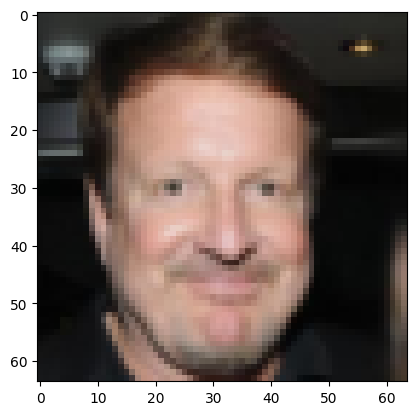

In [10]:
img, _ = next(iter(dataloader))

if img.size(1) == 3:
    plt.imshow(img[0].permute(1, 2, 0) * 0.5 + 0.5)
    plt.show()
else:
    plt.imshow(img[0][0] * 0.5 + 0.5, cmap = 'gray')
    plt.show()

In [11]:
class LinearScheduler:
    def __init__(self, T=1000, start=1e-4, end=2e-2):
        
        self.beta = torch.linspace(start, end, num_time_steps)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0)

In [12]:
class CosineScheduler:
    def __init__(self, T=1000, offset=0.008):

        f_0 = np.cos(0.5*np.pi*offset/(1+offset)) ** 2
        t = torch.linspace(0, T, T+1)
        self.alpha = ((np.cos(0.5*np.pi*(offset + t/T)/(1+offset)) ** 2)/f_0)
        self.beta = torch.zeros(T+1)
        self.beta[1:] = 1 - self.alpha[1:] / self.alpha[:-1]
        self.beta[0] = self.beta[1]/2
        self.beta = torch.clamp(self.beta, min=0.0, max=0.999)

In [13]:
T = 1000
scheduler = CosineScheduler(T)

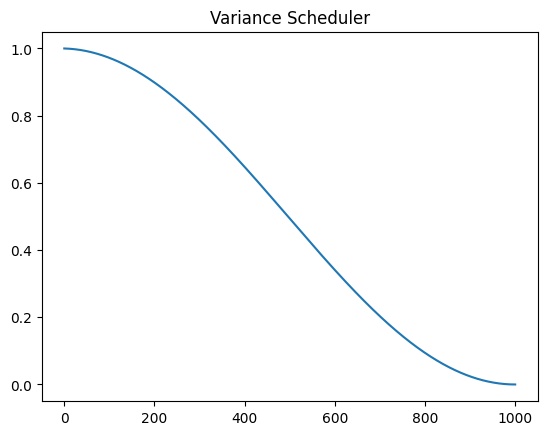

In [14]:
plt.title("Variance Scheduler")
plt.plot(scheduler.alpha)
plt.show()

In [15]:
def q(t, x_0, scheduler):
    noise = np.random.normal(0, 1, x_0.shape)
    x_t = np.sqrt(scheduler.alpha[t]) * x_0 + np.sqrt(1 - scheduler.alpha[t]) * noise
    return x_t

In [16]:
def Q(t, x_0, scheduler):
    
    input_batch_size = x_0.size(0)
    device = x_0.device
    
    noise = torch.randn_like(x_0, device=device)
    
    x_t = torch.sqrt(scheduler.alpha.to(device)[t]).view(input_batch_size, 1, 1, 1) * x_0 + torch.sqrt(1 - scheduler.alpha.to(device)[t]).view(input_batch_size, 1, 1, 1) * noise

    return x_t, noise

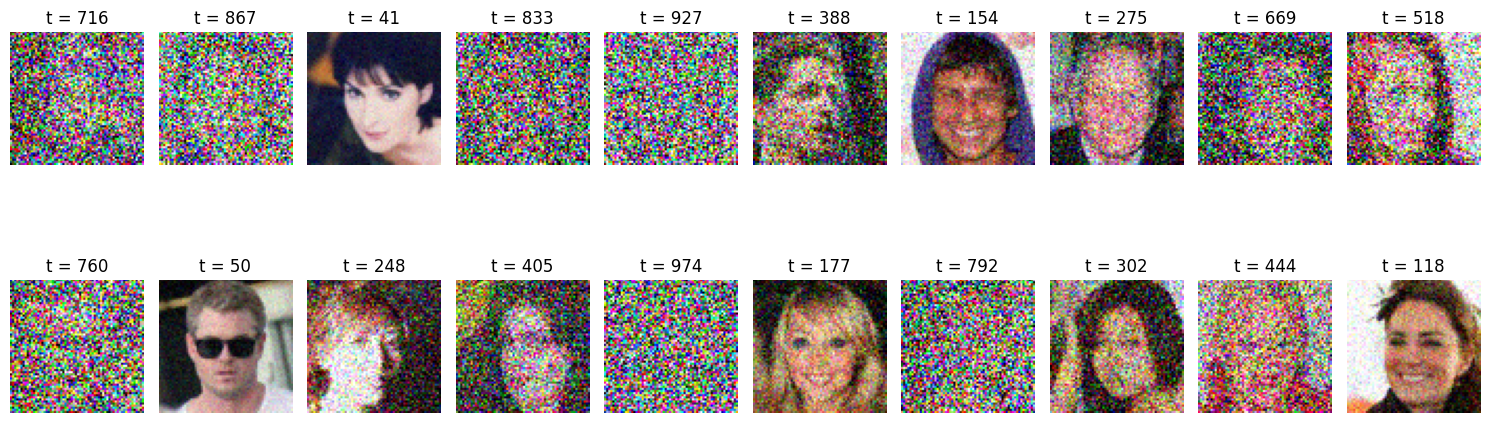

In [17]:
img, _ = next(iter(dataloader))

fig, axes = plt.subplots(2, min(20,len(img))//2, figsize=(15, 6))
axes = axes.flatten()
t  = torch.randint(low=1, high=T, size=(batch_size,))

noised_images, _ = Q(t, img, scheduler)

for i in range(min(20,len(img))):
    
    image = noised_images[i]
    if image.shape[0] == 3:
        image = image.permute(1, 2, 0).numpy()
        axes[i].imshow(image * 0.5 + 0.5)
    else:
        image = image[0].numpy()
        axes[i].imshow(image * 0.5 + 0.5, cmap='gray')
    
    axes[i].set_title(f"t = {t[i].item()}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [18]:
def sample_images(model, scheduler, T, n_images=16, n_channels=3, img_size=32, device=device):

    model.eval()

    x = torch.randn((n_images, n_channels, img_size, img_size), device=device)
    images = []

    for i in tqdm(range(T-1, -1, -1)):
        with torch.no_grad():

            z = torch.randn_like(x, device=device)
            t = torch.full((n_images,), fill_value=i, dtype=torch.int, device='cpu')
            
            if i > 0:
                posterior_variance = scheduler.beta[i] * (1. - scheduler.alpha[i-1]) / (1. - scheduler.alpha[i])
            else:
                posterior_variance = 0.0
            
            pred = model(x, t.to(device))
            x = (1/np.sqrt(1 - scheduler.beta[i])) * (x - (scheduler.beta[i]/np.sqrt(1 - scheduler.alpha[i])) * pred) + np.sqrt(posterior_variance) * z

        if i%50 == 0:
            images.append(x.detach().cpu().permute(0, 2, 3, 1))

    return images

In [19]:
def display_images(image_array, rows=2, cols=5):

    if len(image_array) > rows * cols:
        print("Attention : certaines images ne seront pas affichées.")
    
    _, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(image_array):

            img = image_array[i].numpy()
            img = (img - img.min()) / (img.max() - img.min())

            if img.shape[0] == 3:
                ax.imshow(img)
            else:
                ax.imshow(img,cmap='gray')
            
            ax.axis('off')  # Désactiver les axes
        else:
            ax.axis('off')  # Désactiver les axes pour les cases vides

    plt.tight_layout(pad=0.2)
    plt.show()

In [20]:
def sinusoidal_positional_encoding(t, d_model):
    
    batch_size = t.size(0)
    pe = torch.zeros(batch_size, d_model, device=t.device)
    position = t.unsqueeze(1).float()  # (batch_size, 1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=t.device).float() * -(math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)  # Sinus sur les indices pairs
    pe[:, 1::2] = torch.cos(position * div_term)  # Cosinus sur les indices impairs
    
    return pe

In [21]:
class ConvResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, embedding_dim, groups, dropout):
        super().__init__()
        
        self.block = nn.Sequential(
            nn.GroupNorm(groups, in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.Dropout(p=dropout, inplace=True),
            nn.GroupNorm(groups, out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        )

        self.res_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()
        
        self.embedding_dim = embedding_dim
        
    def forward(self, x, time):
        
        # Calculer l'encodage positionnel
        pos_emb = sinusoidal_positional_encoding(time, self.embedding_dim)  # [batch_size, embedding_dim]
        pos_emb = pos_emb[:, :x.size(1), None, None]  # [batch_size, in_channels, 1, 1]
        
        # Ajouter les embeddings au tenseur d'entrée
        x = x + pos_emb

        residual = self.res_conv(x)
        
        x = self.block(x) + residual
        x = F.relu(x)
        
        return x

In [22]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

In [23]:
class UNetBlock(nn.Module):
    def __init__(self, attention: bool, in_channels, out_channels, embedding_dim, groups, dropout=0.1):
        super().__init__()
        
        self.block1 = ConvResBlock(out_channels, out_channels, embedding_dim, groups, dropout)
        self.block2 = ConvResBlock(out_channels, out_channels, embedding_dim, groups, dropout)

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

        self.attention = Attention(out_channels, 8, dropout) if attention else nn.Identity()
        
    def forward(self, x, time):

        x = self.conv(x)
        x = self.block1(x, time)
        x = self.attention(x)
        x = self.block2(x, time)
        
        return x

In [24]:
class UNetWithPosition(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64, groups=64//2, embedding_dim=64*16):
        super().__init__()
        
        self.encoder1 = UNetBlock(False, in_channels, base_channels, embedding_dim, groups)
        self.encoder2 = UNetBlock(False, base_channels, base_channels*2, embedding_dim, groups)
        self.encoder3 = UNetBlock(True, base_channels*2, base_channels*4, embedding_dim, groups)
        self.encoder4 = UNetBlock(False, base_channels*4, base_channels*8, embedding_dim, groups)
        
        self.bottleneck = UNetBlock(False, base_channels*8, base_channels*16, embedding_dim, groups)

        self.pool = nn.MaxPool2d(2)
        
        self.decoder4 = UNetBlock(False, base_channels*(8+8), base_channels*(8+8), embedding_dim, groups)
        self.decoder3 = UNetBlock(True, base_channels*(8+4), base_channels*(8+4), embedding_dim, groups)
        self.decoder2 = UNetBlock(False, base_channels*(6+2), base_channels*(6+2), embedding_dim, groups)

        self.up4 = nn.ConvTranspose2d(base_channels*16, base_channels*8, kernel_size=4, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(base_channels*16, base_channels*8, kernel_size=4, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(base_channels*12, base_channels*6, kernel_size=4, stride=2, padding=1)
        self.up1 = nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1)

        self.final_conv = nn.Sequential(
            nn.Conv2d(base_channels*5, base_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(base_channels, out_channels, kernel_size=1),
        )
        
    def forward(self, x, time):
        
        # Encoder
        enc1 = self.encoder1(x, time) # 64x64
        enc2 = self.encoder2(self.pool(enc1), time) # 32x32
        enc3 = self.encoder3(self.pool(enc2), time) # 16x16
        enc4 = self.encoder4(self.pool(enc3), time) # 8x8
        
        # Bottleneck
        middle = self.bottleneck(self.pool(enc4), time) # 4x4
        
        # Decoder
        dec4 = self.decoder4(torch.cat((self.up4(middle), enc4), dim=1), time) # 8x8
        dec3 = self.decoder3(torch.cat((self.up3(dec4), enc3), dim=1), time) # 16x16
        dec2 = self.decoder2(torch.cat((self.up2(dec3), enc2), dim=1), time) # 32x32
        dec1 = torch.cat((self.up1(dec2), enc1), dim=1) # 64x64

        out = self.final_conv(dec1)
        
        return out

In [25]:
model = UNetWithPosition(in_channels=3, out_channels=3)
model = model.to(device=device)

In [26]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Nombre de paramètres du modèle : {params}")

Nombre de paramètres du modèle : 145856771


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


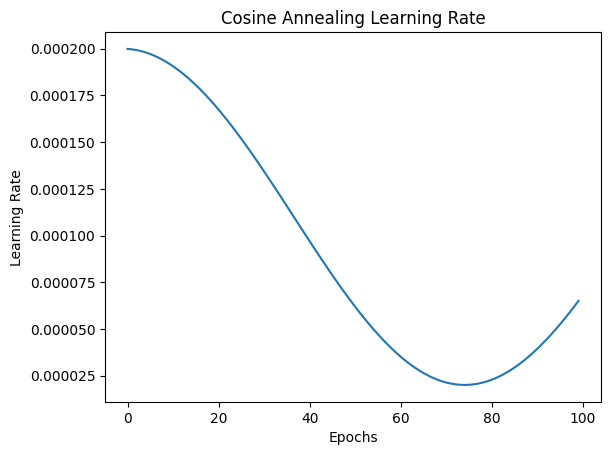

In [27]:
optimizer = torch.optim.AdamW([torch.zeros(1)], lr=2e-4)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=75, eta_min=2e-5)

lrs = []
for epoch in range(100):
    lr_scheduler.step()
    lrs.append(lr_scheduler.get_last_lr()[0])

plt.plot(range(100), lrs)
plt.title("Cosine Annealing Learning Rate")
plt.xlabel("Epochs")
plt.ylabel("Learning Rate")
plt.show()

In [28]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
lr_scheduler = CosineAnnealingLR(optimizer, T_max=75, eta_min=2e-5)

ema_model = torch.optim.swa_utils.AveragedModel(model, multi_avg_fn=torch.optim.swa_utils.get_ema_multi_avg_fn(0.9999))

In [29]:
n_epochs = 100

def training(n_epochs, train_loader, model, criterion, optimizer, lr_scheduler, device, scheduler):

    train_losses = []
    samples = []
    
    scaler = torch.GradScaler('cuda')
    
    for epoch in range(n_epochs):
        
        train_loss = 0

        # train the model
        model.train() # prep model for training
        for data, _ in train_loader:

            data = data.to(device=device)
            t = torch.randint(low=0, high=T, size=(data.size(0),), device=device)
            
            noisy_image, noise = Q(t, data, scheduler)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                
                output = model(noisy_image, t)

                # calculate the loss
                loss = criterion(output, noise)

            # backward pass: compute gradient of the loss with respect to model parameters
            scaler.scale(loss).backward()

            # perform a single optimization step (parameter update)
            scaler.step(optimizer)
            scaler.update()

            # update running training loss
            train_loss += loss.item() * data.size(0)

            # Update EMA every iteration
            ema_model.update_parameters(model)

        lr_scheduler.step()
        
        # calculate average loss over an epoch
        train_loss /= len(train_loader.sampler)
        train_losses.append(train_loss)

        print(f'Epoch: {epoch+1} | Training Loss: {train_loss:.5f}')
        torch.save(model.state_dict(), 'model.pt')
        torch.save(ema_model.state_dict(), "ema_model.pt")

        if epoch%20==0 or epoch==n_epochs-1:
            model.eval()
            print("Sampling...")
            samples.append(sample_images(model, scheduler, T, n_images=8, n_channels=3, img_size=64, device=device))

    torch.optim.swa_utils.update_bn(train_loader, ema_model)

    torch.save(model.state_dict(), 'model.pt')
    torch.save(ema_model.state_dict(), "ema_model.pt")
    
    return train_losses, samples

In [30]:
model = nn.DataParallel(model)
start = tme.perf_counter()
train_losses, samples = training(n_epochs, dataloader, model, criterion, optimizer, lr_scheduler, device, scheduler)
end = tme.perf_counter()
print(f"Training time : {end - start}")

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch: 1 | Training Loss: 0.29037
Sampling...


100%|██████████| 1000/1000 [01:47<00:00,  9.27it/s]


Epoch: 2 | Training Loss: 0.10082
Epoch: 3 | Training Loss: 0.08544
Epoch: 4 | Training Loss: 0.07592
Epoch: 5 | Training Loss: 0.07076
Epoch: 6 | Training Loss: 0.06593
Epoch: 7 | Training Loss: 0.06269
Epoch: 8 | Training Loss: 0.05894
Epoch: 9 | Training Loss: 0.05692
Epoch: 10 | Training Loss: 0.05545
Epoch: 11 | Training Loss: 0.05397
Epoch: 12 | Training Loss: 0.05180
Epoch: 13 | Training Loss: 0.05189
Epoch: 14 | Training Loss: 0.05056
Epoch: 15 | Training Loss: 0.04984
Epoch: 16 | Training Loss: 0.04860
Epoch: 17 | Training Loss: 0.04805
Epoch: 18 | Training Loss: 0.04899
Epoch: 19 | Training Loss: 0.04762
Epoch: 20 | Training Loss: 0.04764
Epoch: 21 | Training Loss: 0.04689
Sampling...


100%|██████████| 1000/1000 [01:47<00:00,  9.29it/s]


Epoch: 22 | Training Loss: 0.04565
Epoch: 23 | Training Loss: 0.04542
Epoch: 24 | Training Loss: 0.04486
Epoch: 25 | Training Loss: 0.04484
Epoch: 26 | Training Loss: 0.04417
Epoch: 27 | Training Loss: 0.04411
Epoch: 28 | Training Loss: 0.04322
Epoch: 29 | Training Loss: 0.04310
Epoch: 30 | Training Loss: 0.04225
Epoch: 31 | Training Loss: 0.04281
Epoch: 32 | Training Loss: 0.04254
Epoch: 33 | Training Loss: 0.04213
Epoch: 34 | Training Loss: 0.04296
Epoch: 35 | Training Loss: 0.04204
Epoch: 36 | Training Loss: 0.04171
Epoch: 37 | Training Loss: 0.04161
Epoch: 38 | Training Loss: 0.04084
Epoch: 39 | Training Loss: 0.04101
Epoch: 40 | Training Loss: 0.04083
Epoch: 41 | Training Loss: 0.04176
Sampling...


100%|██████████| 1000/1000 [01:47<00:00,  9.28it/s]


Epoch: 42 | Training Loss: 0.04013
Epoch: 43 | Training Loss: 0.03960
Epoch: 44 | Training Loss: 0.04028
Epoch: 45 | Training Loss: 0.04018
Epoch: 46 | Training Loss: 0.04000
Epoch: 47 | Training Loss: 0.03948
Epoch: 48 | Training Loss: 0.04028
Epoch: 49 | Training Loss: 0.03958
Epoch: 50 | Training Loss: 0.03923
Epoch: 51 | Training Loss: 0.03996
Epoch: 52 | Training Loss: 0.03955
Epoch: 53 | Training Loss: 0.03857
Epoch: 54 | Training Loss: 0.03922
Epoch: 55 | Training Loss: 0.03860
Epoch: 56 | Training Loss: 0.03878
Epoch: 57 | Training Loss: 0.03847
Epoch: 58 | Training Loss: 0.03964
Epoch: 59 | Training Loss: 0.03911
Epoch: 60 | Training Loss: 0.03873
Epoch: 61 | Training Loss: 0.03837
Sampling...


100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]


Epoch: 62 | Training Loss: 0.03845
Epoch: 63 | Training Loss: 0.03861
Epoch: 64 | Training Loss: 0.03929
Epoch: 65 | Training Loss: 0.03840
Epoch: 66 | Training Loss: 0.03830
Epoch: 67 | Training Loss: 0.03779
Epoch: 68 | Training Loss: 0.03912
Epoch: 69 | Training Loss: 0.03831
Epoch: 70 | Training Loss: 0.03846
Epoch: 71 | Training Loss: 0.03880
Epoch: 72 | Training Loss: 0.03839
Epoch: 73 | Training Loss: 0.03792
Epoch: 74 | Training Loss: 0.03855
Epoch: 75 | Training Loss: 0.03850
Epoch: 76 | Training Loss: 0.03800
Epoch: 77 | Training Loss: 0.03754
Epoch: 78 | Training Loss: 0.03754
Epoch: 79 | Training Loss: 0.03742
Epoch: 80 | Training Loss: 0.03766
Epoch: 81 | Training Loss: 0.03786
Sampling...


100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]


Epoch: 82 | Training Loss: 0.03839
Epoch: 83 | Training Loss: 0.03807
Epoch: 84 | Training Loss: 0.03787
Epoch: 85 | Training Loss: 0.03866
Epoch: 86 | Training Loss: 0.03784
Epoch: 87 | Training Loss: 0.03777
Epoch: 88 | Training Loss: 0.03819
Epoch: 89 | Training Loss: 0.03833
Epoch: 90 | Training Loss: 0.03786
Epoch: 91 | Training Loss: 0.03809
Epoch: 92 | Training Loss: 0.03771
Epoch: 93 | Training Loss: 0.03769
Epoch: 94 | Training Loss: 0.03759
Epoch: 95 | Training Loss: 0.03762
Epoch: 96 | Training Loss: 0.03812
Epoch: 97 | Training Loss: 0.03803
Epoch: 98 | Training Loss: 0.03791
Epoch: 99 | Training Loss: 0.03824
Epoch: 100 | Training Loss: 0.03862
Sampling...


100%|██████████| 1000/1000 [01:47<00:00,  9.26it/s]


Training time : 25743.012090272


In [31]:
torch.cuda.empty_cache()

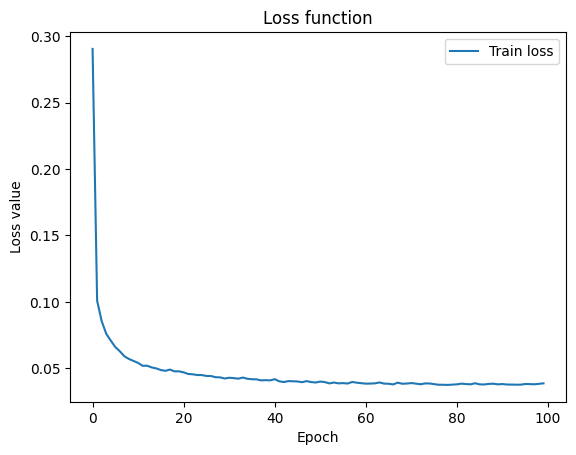

In [32]:
plt.plot(train_losses, label='Train loss')
plt.title('Loss function')
plt.xlabel('Epoch', size=10)
plt.ylabel('Loss value', size=10)
plt.legend()
plt.show()

In [33]:
model.load_state_dict(torch.load("model.pt", weights_only=True))
ema_model.load_state_dict(torch.load("ema_model.pt", weights_only=True))

<All keys matched successfully>

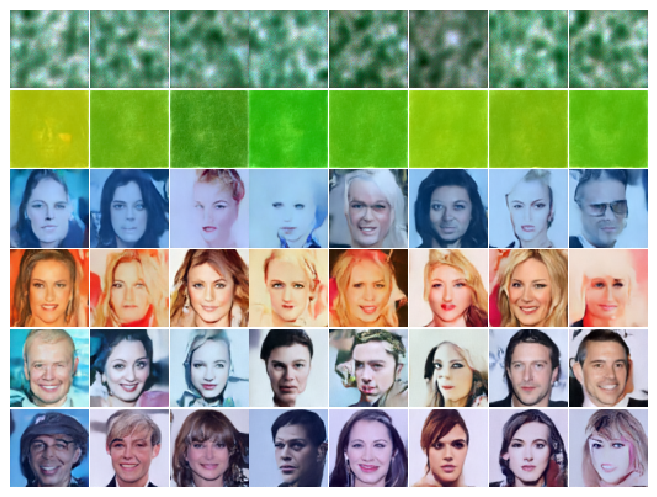

In [34]:
fig, axs = plt.subplots(n_epochs//20 + 1, 8)
for i in range(n_epochs//20 + 1):
    for j in range(8):
        img = samples[i][-1][j].numpy()
        img = (img - img.min()) / (img.max() - img.min())
        axs[i,j].imshow(img, interpolation='nearest')
        axs[i,j].axis('off') 
plt.tight_layout(pad=0.1)
plt.show()

In [35]:
images = sample_images(model, scheduler, T, n_images=32, img_size=64)

100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]


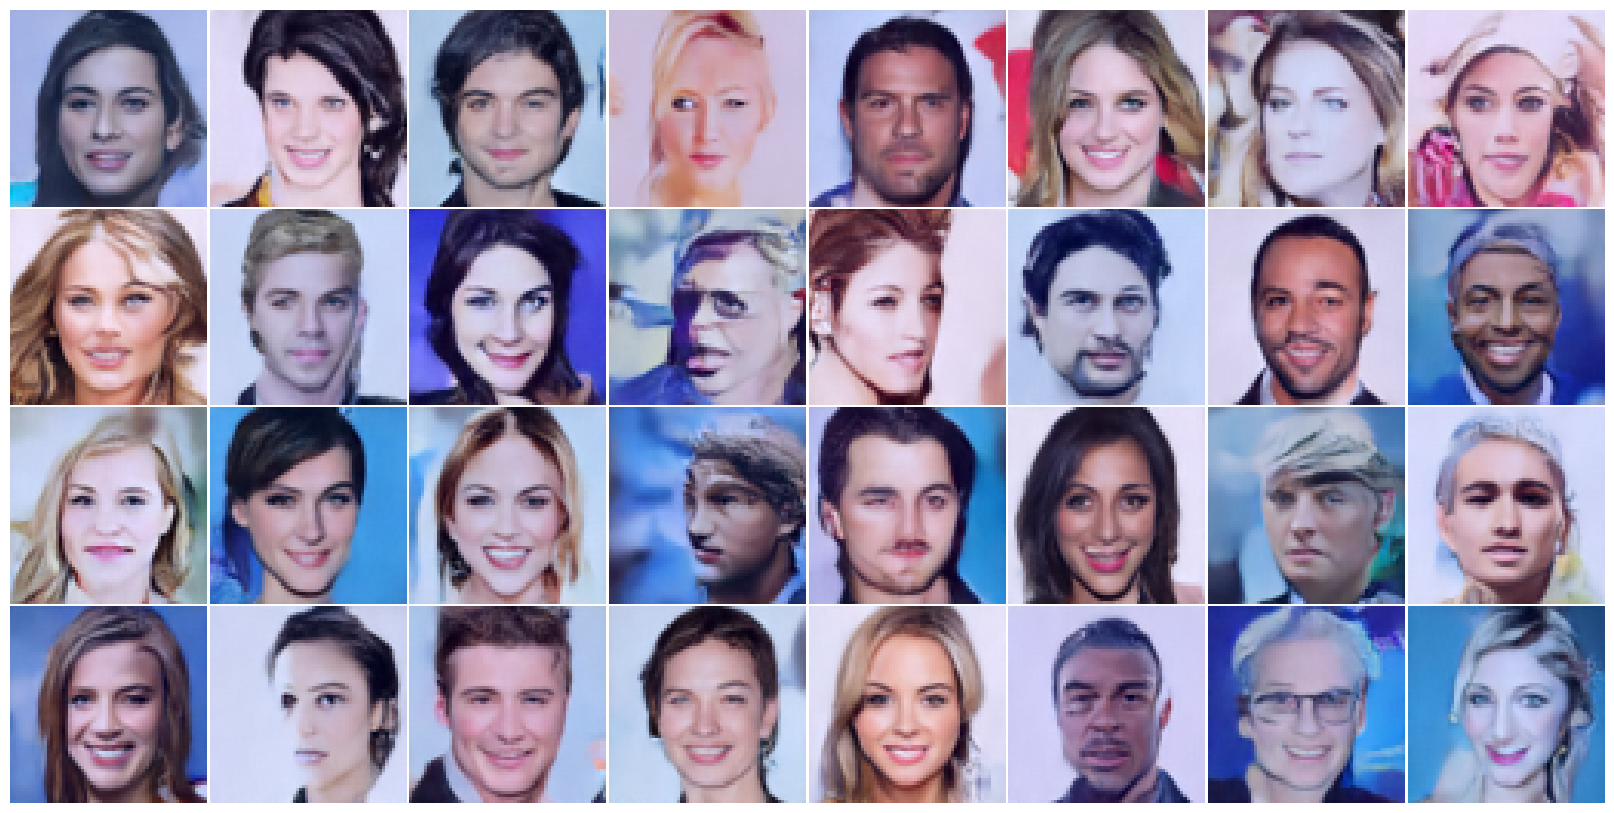

In [36]:
display_images(images[-1], 4, 8)

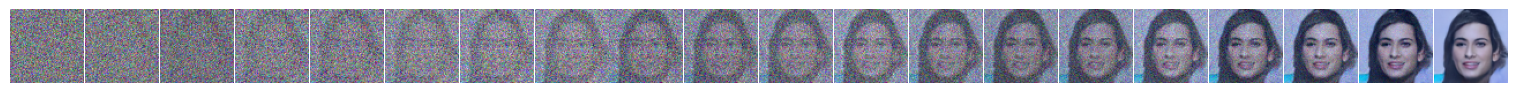

In [37]:
num_images = len(images)

fig, axes = plt.subplots(1, num_images, figsize=(15, 8))

for i, ax in enumerate(axes):
    img = images[i][0]
    img = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout(pad=0.1)
plt.show()

In [1]:
print('test git')

test git


In [2]:
print('test git 2')
print('test git 3')

test git 2
test git 3
